In [1]:
!git clone https://github.com/congnghia0609/ntc-scv.git

Cloning into 'ntc-scv'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 39 (delta 0), reused 4 (delta 0), pack-reused 35
Receiving objects: 100% (39/39), 186.94 MiB | 36.83 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [2]:
!unzip /content/ntc-scv/data/data_test.zip -d ./data
!unzip /content/ntc-scv/data/data_train.zip -d ./data
!rm -rf ./ntc-scv/

Archive:  /content/ntc-scv/data/data_test.zip
replace ./data/data_test/test/neg/10.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/ntc-scv/data/data_train.zip
replace ./data/data_train/test/neg/10013.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1]:
PATH = {"train" : "./data/data_train/train",
        "val" : "./data/data_train/test",
        "test" : "./data/data_test/test"}

In [2]:
import os
import pandas as pd

def load_data(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                content = f.read()
            if label == "neg":
                label = 0
            if label == "pos":
                label = 1
            data = {
                "sentence" : content,
                "label" : label
            }
            examples.append(data)
    return pd.DataFrame(examples)

In [3]:
train_df = load_data(PATH["train"])
val_df = load_data(PATH["val"])
test_df = load_data(PATH["test"])

In [4]:
!pip install langid
from langid.langid import LanguageIdentifier, model
def identify_vn(df):
    identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    not_vi_idx = set()
    THRESHOLD = 0.9
    for idx, row in df.iterrows():
        score = identifier.classify(row["sentence"])
        if score[0] != "vi" or (score[0] == "vi" and score[1] <= THRESHOLD):
            not_vi_idx.add(idx)
    vi_df = df[~df.index.isin(not_vi_idx)]
    not_vi_df = df[df.index.isin(not_vi_idx)]
    return vi_df, not_vi_df
train_df_vi, train_df_other = identify_vn(train_df)

In [5]:
import re
import string
def preprocess_text(text):
    #remove urls https://www.example.com
    url_pattern = re.compile(r"https?\S*")
    text = url_pattern.sub(r" ", text)
    #remove html tag
    html_pattern = re.compile(r"<[^<>]*>")
    text = html_pattern.sub(r" ", text)
    #remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")
    #remove emoij
    emoji_pattern = re.compile("["
                               "\U0001F600-\U0001F64F"  # Emoticons
                               "\U0001F300-\U0001F5FF"  # Miscellaneous Symbols and Pictographs
                               "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
                               "\U0001F700-\U0001F77F"  # Alchemical Symbols
                               "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               "\U0001FA00-\U0001FA6F"  # Chess Symbols
                               "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               "\U00002702-\U000027B0"  # Dingbat Symbols
                               "\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(" ", text)
    text = " ".join(text.split())
    text = text.lower()
    return text

In [6]:
train_df_vi["preprocess_sentence"] = [preprocess_text(row["sentence"]) for idx, row in train_df_vi.iterrows()]
val_df["preprocess_sentence"] = [preprocess_text(row["sentence"]) for idx, row in val_df.iterrows()]
test_df["preprocess_sentence"] = [preprocess_text(row["sentence"]) for idx, row in test_df.iterrows()]

<ipython-input-6-25c8292a879f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_vi["preprocess_sentence"] = [preprocess_text(row["sentence"]) for idx, row in train_df_vi.iterrows()]


In [7]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
tokenizer = get_tokenizer("basic_english")
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)
vocab_size = 10000
vocabulary = build_vocab_from_iterator(yield_tokens(train_df_vi["preprocess_sentence"], tokenizer),
                                       max_tokens = vocab_size,
                                       specials=["<pad>","<unk>"])
vocabulary.set_default_index(vocabulary["<unk>"])

In [8]:
from torchtext.data.functional import to_map_style_dataset
def prepare_dataset(df):
    for index, row in df.iterrows():
        sentence = row["preprocess_sentence"]
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row["label"]
        yield encoded_sentence, label
train_dataset = prepare_dataset(train_df_vi)
train_dataset = to_map_style_dataset(train_dataset)

val_dataset = prepare_dataset(val_df)
val_dataset = to_map_style_dataset(val_dataset)

test_dataset = prepare_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

In [9]:
import torch
seq_length = 100
def collate_batch(batch):
    sentences, labels = list(zip(*batch))
    encoded_sentences = [sentence+([0] * (seq_length-len(sentence))) if len(sentence) < seq_length else sentence[:seq_length] for sentence in sentences]
    encoded_sentences = torch.tensor(encoded_sentences, dtype=torch.int64)
    labels = torch.tensor(labels)
    return encoded_sentences, labels

In [10]:
from torch.utils.data import DataLoader
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [11]:
import time
def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print("| epoch {:3d} | {:5d}/{:5d} batches | accuracy {:8.3f}".format(epoch, idx, len(train_dataloader), total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()
    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [12]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            losses.append(loss.item())
            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)
    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [13]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')
        times.append(time.time() - epoch_start_time)
        print("-"*59)
        print("| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} | Valid Accuracy {:8.3f} | Valid Loss {:8.3f}".format(epoch, times[-1], train_acc, train_loss, eval_acc, eval_loss))
        print("-"*59)
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_acc' : train_accs,
        'train_loss' : train_losses,
        'valid_acc' : eval_accs,
        'valid_loss' : eval_losses,
        'time' : times
    }
    return model, metrics

In [14]:
import matplotlib.pyplot as plt
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    axs[0].plot(epochs, train_accs, label="Training")
    axs[0].plot(epochs, eval_accs, label="Evaluation")
    axs[1].plot(epochs, train_losses, label="Training")
    axs[1].plot(epochs, eval_losses, label="Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

In [15]:
import torch.nn as nn

In [16]:
class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_length, device='cpu'):
        super().__init__()
        self.device = device
        self.word_emb = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim)
        self.pos_emb = nn.Embedding(
            num_embeddings=max_length,
            embedding_dim=embed_dim
        )

    def forward(self, x):
        N, seq_len = x.size()
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        output1 = self.word_emb(x)
        output2 = self.pos_emb(positions)
        output =  output1 + output2
        return output

class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim = embed_dim,
            num_heads = num_heads,
            batch_first = True
        )
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(query + attn_output)
        ffn_output = self.ffn(attn_output)
        ffn_output = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(out_1 + ffn_output)
        return out_2

class TransformerEncoder(nn.Module):
    def __init__(self, src_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout=0.1, device='cpu'):
        super().__init__()
        self.embedding = TokenAndPositionEmbedding(src_vocab_size, embed_dim, max_length, device)
        self.layers = nn.ModuleList(
            [
                TransformerEncoderBlock(embed_dim, num_heads, ff_dim, dropout) for i in range(num_layers)
            ]
        )

    def forward(self, x):
        output = self.embedding(x)
        for layer in self.layers:
            output = layer(output, output, output)
        return output

In [17]:
class TransformerEncoderCls(nn.Module):
    def __init__(self, vocab_size, max_length, embed_dim, num_layers, num_heads, ff_dim, dropout=0.1, device='cpu'):
        super().__init__()
        self.encoder = TransformerEncoder(vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout, device)
        self.pooling = nn.AvgPool1d(kernel_size=max_length)
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=2)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.encoder(x)
        output = self.pooling(output.permute(0,2,1)).squeeze()
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

In [18]:
import torch.optim as optim
vocab_size = 10000
max_length = 100
embed_dim = 200
num_layers = 2
num_heads = 4
ff_dim = 128
dropout = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerEncoderCls(vocab_size, max_length, embed_dim, num_layers, num_heads, ff_dim, dropout, device).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.00005)
num_epochs = 10
save_model = './model'
os.makedirs(save_model, exist_ok=True)
model_name = "model"
model, metrics = train(model, model_name, save_model, optimizer, criterion, train_dataloader, val_dataloader, num_epochs, device)

| epoch   1 |    50/  233 batches | accuracy    0.528
| epoch   1 |   100/  233 batches | accuracy    0.623
| epoch   1 |   150/  233 batches | accuracy    0.687
| epoch   1 |   200/  233 batches | accuracy    0.746
-----------------------------------------------------------
| End of epoch   1 | Time:  8.26s | Train Accuracy    0.767 | Train Loss    0.613 | Valid Accuracy    0.767 | Valid Loss    0.496
-----------------------------------------------------------
| epoch   2 |    50/  233 batches | accuracy    0.783
| epoch   2 |   100/  233 batches | accuracy    0.799
| epoch   2 |   150/  233 batches | accuracy    0.798
| epoch   2 |   200/  233 batches | accuracy    0.802
-----------------------------------------------------------
| End of epoch   2 | Time:  7.52s | Train Accuracy    0.812 | Train Loss    0.443 | Valid Accuracy    0.802 | Valid Loss    0.434
-----------------------------------------------------------
| epoch   3 |    50/  233 batches | accuracy    0.826
| epoch   3 | 

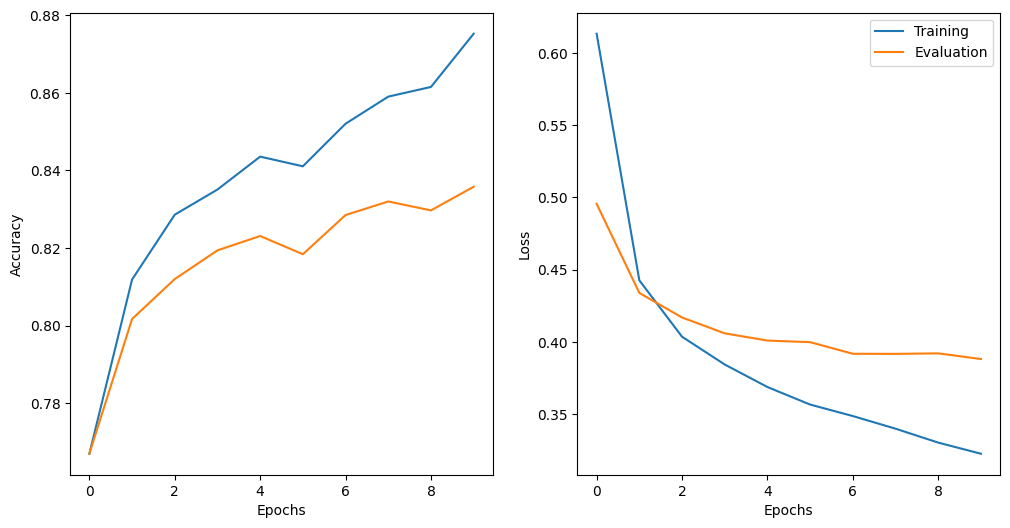

In [19]:
plot_result(num_epochs, metrics["train_acc"], metrics["valid_acc"], metrics["train_loss"], metrics["valid_loss"])

In [20]:
test_acc, test_loss = evaluate_epoch(model, criterion, test_dataloader, device)
test_acc

0.8447

In [62]:
s = "trời mưa nhưng sao không khí của quán quá hầm hực, tôi sẽ không bao giờ ghé lại quán này"
sentence = vocabulary(tokenizer(s))
encoded_sentence = sentence+([0] * (seq_length-len(sentence))) if len(sentence) < seq_length else sentence[:seq_length]
torch_sentence = torch.tensor(encoded_sentence).unsqueeze(0).to(device)
print('Negative' if model(torch_sentence).argmax(0).item() == 0 else 'Positive')

Negative
